In [1]:
import numpy as np

def generate_qpsk(K, num_samples):
    # QPSK: {±1 ± j} / sqrt(2)
    const = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    idx = np.random.randint(0, 4, size=(num_samples, K))
    return const[idx]  # (num_samples, K)

def one_bit_dac(x, eta):
    # x: (..., )
    xr = np.sign(np.real(x))
    xi = np.sign(np.imag(x))
    xr[xr == 0] = 1
    xi[xi == 0] = 1
    return np.sqrt(eta/2.0) * (xr + 1j*xi)

def simulate_quant_error_corr(L=32, K=1, num_samples=40000):
    """
    L: AP 数（= fronthaul DAC 数）
    K: 用户数（= data streams 数）
    num_samples: Monte Carlo 样本数
    """
    # Rayleigh 信道 H: L x K
    H = (np.random.randn(L, K) + 1j*np.random.randn(L, K)) / np.sqrt(2)
    W = np.conj(H)  # MRT / CB 预编码

    # 生成数据符号
    s = generate_qpsk(K, num_samples)    # (num_samples, K)

    # 预编码信号 x: (num_samples, L)
    x = s @ W.T

    # 对每个样本做归一化，使每次发射总功率约为 1
    power = np.mean(np.abs(x)**2, axis=1, keepdims=True)
    x = x / np.sqrt(power + 1e-12)

    # 1-bit DAC 量化（无 dithering）
    eta = 1.0 / L
    x_q = one_bit_dac(x, eta)

    # 量化失真
    e = x_q - x

    # 估计相关系数矩阵
    e_center = e - np.mean(e, axis=0, keepdims=True)
    cov = e_center.conj().T @ e_center / (num_samples - 1)   # L x L
    var = np.real(np.diag(cov))
    std = np.sqrt(var + 1e-15)
    corr = cov / (std[:, None] * std[None, :])               # 相关系数矩阵

    # 统计平均绝对相关系数（只看非对角）
    Lh = corr.shape[0]
    off = corr.copy()
    off[np.eye(Lh, dtype=bool)] = 0
    avg_abs = np.mean(np.abs(off[np.triu_indices(Lh, k=1)]))
    max_abs = np.max(np.abs(off[np.triu_indices(Lh, k=1)]))

    return corr, avg_abs, max_abs

if __name__ == "__main__":
    for K in [1, 2, 4, 8, 16, 32]:
        corr, avg_abs, max_abs = simulate_quant_error_corr(L=32, K=K, num_samples=40000)
        print(f"K = {K}: avg |corr(off-diag)| = {avg_abs:.3f}, max |corr| = {max_abs:.3f}")


K = 1: avg |corr(off-diag)| = 1.000, max |corr| = 1.000
K = 2: avg |corr(off-diag)| = 0.651, max |corr| = 1.000
K = 4: avg |corr(off-diag)| = 0.440, max |corr| = 0.912
K = 8: avg |corr(off-diag)| = 0.303, max |corr| = 0.684
K = 16: avg |corr(off-diag)| = 0.216, max |corr| = 0.561
K = 32: avg |corr(off-diag)| = 0.150, max |corr| = 0.445


[Fig1] K = 1
[Fig1] K = 2
[Fig1] K = 4
[Fig1] K = 8
[Fig1] K = 16
[Fig1] K = 32


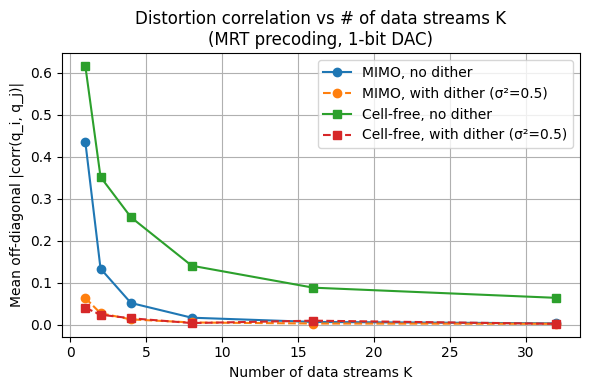


[Fig2] Fix K = 1, sweep sigma2
  sigma2 = 1.0000e-03
  sigma2 = 3.7276e-03
  sigma2 = 1.3895e-02
  sigma2 = 5.1795e-02
  sigma2 = 1.9307e-01
  sigma2 = 7.1969e-01
  sigma2 = 2.6827e+00
  sigma2 = 1.0000e+01


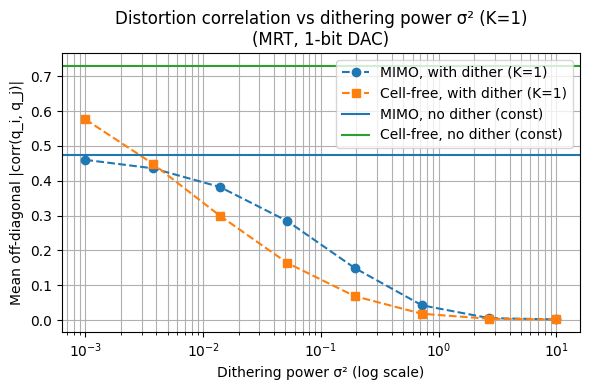

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ================== 相关性工具 ==================

def compute_corr_matrix(Z):
    """
    计算复矩阵 Z ∈ C^{N x T} 的相关系数矩阵：
        - Z 的每一行视为一个随机变量（对应一个发射天线）
        - T 是时间/样本数
    返回 R ∈ C^{N x N}, R_ij = Corr(Z_i, Z_j)
    """
    N, T = Z.shape
    Zc = Z - Z.mean(axis=1, keepdims=True)          # 去均值
    cov = (Zc @ Zc.conj().T) / T                    # 协方差矩阵
    std = np.sqrt(np.real(np.diag(cov)) + 1e-12)    # 每个天线的标准差
    denom = std[:, None] * std[None, :] + 1e-12     # 防止除零
    R = cov / denom
    return R

def mean_offdiag_abs(R):
    """
    计算相关系数矩阵 R 的非对角元素 |R_ij| 的平均值
    """
    N = R.shape[0]
    mask = ~np.eye(N, dtype=bool)
    return np.mean(np.abs(R[mask]))


# ===== 生成数据流 / 信道 / 预编码 =====

def generate_gaussian_streams(K_streams, num_samples):
    """
    生成 K_streams 条独立复高斯 data streams：CN(0,1)
    形状为 (K_streams, num_samples)
    """
    return (np.random.randn(K_streams, num_samples)
            + 1j * np.random.randn(K_streams, num_samples)) / np.sqrt(2.0)

def generate_channel(K_streams, N_tx):
    """
    生成 K_streams 条数据流、N_tx 根发射天线的 Rayleigh 信道矩阵:
        H ∈ C^{K_streams x N_tx}, 每个元素 ~ CN(0,1)
    这将用作“集中式 MIMO”的信道
    """
    return (np.random.randn(K_streams, N_tx)
            + 1j * np.random.randn(K_streams, N_tx)) / np.sqrt(2.0)

def generate_cellfree_channel(K_streams, N_tx,
                              ap_positions,
                              cell_size=1.0,
                              pathloss_exp=3.7,
                              d_min=0.05):
    """
    生成 Cell-free 信道:
        - N_tx 个 AP，位置由 ap_positions 给出，形状 (N_tx, 2)
        - K_streams 个单天线用户，随机散布在 [0, cell_size]^2 区域
        - 大尺度衰落: beta_{k,m} ∝ (d_ref / d_{k,m})^{pathloss_exp}
        - 小尺度 Rayleigh: h_{k,m} ~ CN(0,1)

    输出:
        H_cf ∈ C^{K_streams x N_tx}
    """
    # 随机生成用户位置
    ue_pos = np.random.rand(K_streams, 2) * cell_size  # (K_streams, 2)

    # 计算所有 UE-AP 之间的距离
    # d_{k,m} = || ue_k - ap_m ||
    ue_expanded = ue_pos[:, None, :]           # (K, 1, 2)
    ap_expanded = ap_positions[None, :, :]     # (1, N_tx, 2)
    diff = ue_expanded - ap_expanded           # (K, N_tx, 2)
    dist = np.linalg.norm(diff, axis=2)        # (K, N_tx)

    # 防止距离过小
    dist = np.maximum(dist, d_min)

    # 大尺度衰落 (未加常数因子，反正只是相对量)
    beta = dist ** (-pathloss_exp)             # (K, N_tx)

    # 小尺度 Rayleigh
    h_small = (np.random.randn(K_streams, N_tx)
               + 1j * np.random.randn(K_streams, N_tx)) / np.sqrt(2.0)

    # 合成信道
    H_cf = np.sqrt(beta) * h_small
    return H_cf

def mrt_precoder(H):
    """
    MRT 预编码：
        给定 H ∈ C^{K_streams x N_tx}
        返回 W = H^H ∈ C^{N_tx x K_streams}
    """
    return H.conj().T

def estimate_bussgang_alpha(x_in, x_q):
    """
    alpha = E[ x_q * x_in^* ] / E[ |x_in|^2 ]
    按元素和时间平均，估计标量 Bussgang 增益
    """
    num = np.mean(x_q * np.conj(x_in))
    den = np.mean(np.abs(x_in) ** 2)
    return float(np.real(num / (den + 1e-12)))

# ===== 1-bit DAC & dithering =====

def quantizer(x, eta=1.0):
    """
    1-bit DAC 量化器，对应论文中的定义：
        Q(x) = sqrt(eta/2) * (sgn(Re{x}) + j * sgn(Im{x}))
    """
    x = np.asarray(x)

    # 实部、虚部的符号
    xr = np.sign(x.real)
    xi = np.sign(x.imag)

    # 把为 0 的地方也强制设为 +1，保证取值 ∈ {+1, -1}
    xr[xr == 0] = 1.0
    xi[xi == 0] = 1.0

    scale = np.sqrt(eta / 2.0)
    xq = scale * (xr + 1j * xi)

    return xq


def add_dither(x, sigma2):
    """
    对输入向量 x 加复高斯 dithering: d ~ CN(0, sigma2)
    """
    if sigma2 <= 0:
        return x

    # CN(0, sigma2) = N(0, sigma2/2) + j*N(0, sigma2/2)
    std = np.sqrt(sigma2 / 2)
    d = std * (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape))

    return x + d


# ================== 仿真参数 ==================

N_tx = 32                              # 发射天线数 / AP 数
K_list = [1, 2, 4, 8, 16, 32]          # 不同的 data streams 数量
num_samples = 200000                   # 时间样本数（越大统计越稳定）
eta_base = 1.0 / N_tx                  # DAC 缩放因子
sigma2_dither_fixed = 0.5              # 图1 用的固定 dithering 方差

np.random.seed(2025)

# 为 cell-free 预先生成 AP 位置（固定拓扑）
cell_size = 10.0
ap_positions = np.random.rand(N_tx, 2) * cell_size  # (N_tx, 2)

# ================== 图 1: 横轴为 K ==================

mimo_no_dither_vsK = []
mimo_with_dither_vsK = []
cf_no_dither_vsK = []
cf_with_dither_vsK = []

for K_streams in K_list:
    print(f"[Fig1] K = {K_streams}")

    eta = eta_base

    # ========= 1) MIMO 信道 =========
    H_mimo = generate_channel(K_streams, N_tx)   # K x N_tx
    W_mimo = mrt_precoder(H_mimo)               # N_tx x K
    s = generate_gaussian_streams(K_streams, num_samples)  # K x T

    x_mimo = W_mimo @ s                         # N_tx x T
    # 归一化总功率
    x_mimo = x_mimo / np.sqrt(np.mean(np.abs(x_mimo) ** 2))

    # ---- 无 dithering ----
    x_in_no = x_mimo
    xq_no = quantizer(x_in_no, eta=eta)
    alpha_no = estimate_bussgang_alpha(x_in_no, xq_no)
    q_no = xq_no - alpha_no * x_in_no

    R_q_no = compute_corr_matrix(q_no)
    mimo_no_dither_vsK.append(mean_offdiag_abs(R_q_no))

    # ---- 有 dithering ----
    x_in_d = add_dither(x_mimo, sigma2=sigma2_dither_fixed)
    xq_d = quantizer(x_in_d, eta=eta)
    alpha_d = estimate_bussgang_alpha(x_in_d, xq_d)
    q_d = xq_d - alpha_d * x_in_d

    R_q_d = compute_corr_matrix(q_d)
    mimo_with_dither_vsK.append(mean_offdiag_abs(R_q_d))

    # ========= 2) Cell-free 信道 =========
    H_cf = generate_cellfree_channel(K_streams, N_tx,
                                     ap_positions=ap_positions,
                                     cell_size=cell_size,
                                     pathloss_exp=3.7,
                                     d_min=0.05)
    W_cf = mrt_precoder(H_cf)                    # N_tx x K
    s_cf = generate_gaussian_streams(K_streams, num_samples)

    x_cf = W_cf @ s_cf                           # N_tx x T
    x_cf = x_cf / np.sqrt(np.mean(np.abs(x_cf) ** 2))

    # ---- 无 dithering ----
    x_in_no_cf = x_cf
    xq_no_cf = quantizer(x_in_no_cf, eta=eta)
    alpha_no_cf = estimate_bussgang_alpha(x_in_no_cf, xq_no_cf)
    q_no_cf = xq_no_cf - alpha_no_cf * x_in_no_cf

    R_q_no_cf = compute_corr_matrix(q_no_cf)
    cf_no_dither_vsK.append(mean_offdiag_abs(R_q_no_cf))

    # ---- 有 dithering ----
    x_in_d_cf = add_dither(x_cf, sigma2=sigma2_dither_fixed)
    xq_d_cf = quantizer(x_in_d_cf, eta=eta)
    alpha_d_cf = estimate_bussgang_alpha(x_in_d_cf, xq_d_cf)
    q_d_cf = xq_d_cf - alpha_d_cf * x_in_d_cf

    R_q_d_cf = compute_corr_matrix(q_d_cf)
    cf_with_dither_vsK.append(mean_offdiag_abs(R_q_d_cf))

# 画图 1
plt.figure(figsize=(6, 4))
plt.plot(K_list, mimo_no_dither_vsK, 'o-', label='MIMO, no dither')
plt.plot(K_list, mimo_with_dither_vsK, 'o--', label=f'MIMO, with dither (σ²={sigma2_dither_fixed})')
plt.plot(K_list, cf_no_dither_vsK, 's-', label='Cell-free, no dither')
plt.plot(K_list, cf_with_dither_vsK, 's--', label=f'Cell-free, with dither (σ²={sigma2_dither_fixed})')
plt.xlabel("Number of data streams K")
plt.ylabel("Mean off-diagonal |corr(q_i, q_j)|")
plt.title("Distortion correlation vs # of data streams K\n(MRT precoding, 1-bit DAC)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ================== 图 2: 横轴为 dithering 能量 σ² ==================

K_fixed = 1
sigma2_list = np.logspace(-3, 1, 8)  # 10^-3 ~ 10^1

mimo_with_dither_vs_sigma = []
cf_with_dither_vs_sigma = []

print("\n[Fig2] Fix K = 1, sweep sigma2")

# 固定 K=1 时的 no-dither 基准
eta = eta_base

# --- MIMO, no dither baseline ---
H_mimo = generate_channel(K_fixed, N_tx)
W_mimo = mrt_precoder(H_mimo)
s = generate_gaussian_streams(K_fixed, num_samples)
x_mimo = W_mimo @ s
x_mimo = x_mimo / np.sqrt(np.mean(np.abs(x_mimo) ** 2))

x_in_no = x_mimo
xq_no = quantizer(x_in_no, eta=eta)
alpha_no = estimate_bussgang_alpha(x_in_no, xq_no)
q_no = xq_no - alpha_no * x_in_no
R_q_no = compute_corr_matrix(q_no)
mimo_no_dither_const = mean_offdiag_abs(R_q_no)

# --- Cell-free, no dither baseline ---
H_cf = generate_cellfree_channel(K_fixed, N_tx,
                                 ap_positions=ap_positions,
                                 cell_size=cell_size,
                                 pathloss_exp=3.7,
                                 d_min=0.05)
W_cf = mrt_precoder(H_cf)
s_cf = generate_gaussian_streams(K_fixed, num_samples)
x_cf = W_cf @ s_cf
x_cf = x_cf / np.sqrt(np.mean(np.abs(x_cf) ** 2))

x_in_no_cf = x_cf
xq_no_cf = quantizer(x_in_no_cf, eta=eta)
alpha_no_cf = estimate_bussgang_alpha(x_in_no_cf, xq_no_cf)
q_no_cf = xq_no_cf - alpha_no_cf * x_in_no_cf
R_q_no_cf = compute_corr_matrix(q_no_cf)
cf_no_dither_const = mean_offdiag_abs(R_q_no_cf)

for sigma2 in sigma2_list:
    print(f"  sigma2 = {sigma2:.4e}")

    # MIMO, with dither
    x_in_d = add_dither(x_mimo, sigma2=sigma2)
    xq_d = quantizer(x_in_d, eta=eta)
    alpha_d = estimate_bussgang_alpha(x_in_d, xq_d)
    q_d = xq_d - alpha_d * x_in_d
    R_q_d = compute_corr_matrix(q_d)
    mimo_with_dither_vs_sigma.append(mean_offdiag_abs(R_q_d))

    # Cell-free, with dither
    x_in_d_cf = add_dither(x_cf, sigma2=sigma2)
    xq_d_cf = quantizer(x_in_d_cf, eta=eta)
    alpha_d_cf = estimate_bussgang_alpha(x_in_d_cf, xq_d_cf)
    q_d_cf = xq_d_cf - alpha_d_cf * x_in_d_cf
    R_q_d_cf = compute_corr_matrix(q_d_cf)
    cf_with_dither_vs_sigma.append(mean_offdiag_abs(R_q_d_cf))

# 画图 2
plt.figure(figsize=(6, 4))
plt.semilogx(sigma2_list, mimo_with_dither_vs_sigma, 'o--',
             label=f'MIMO, with dither (K={K_fixed})')
plt.semilogx(sigma2_list, cf_with_dither_vs_sigma, 's--',
             label=f'Cell-free, with dither (K={K_fixed})')

plt.axhline(mimo_no_dither_const, color='C0', linestyle='-',
            label='MIMO, no dither (const)')
plt.axhline(cf_no_dither_const, color='C2', linestyle='-',
            label='Cell-free, no dither (const)')

plt.xlabel("Dithering power σ² (log scale)")
plt.ylabel("Mean off-diagonal |corr(q_i, q_j)|")
plt.title(f"Distortion correlation vs dithering power σ² (K={K_fixed})\n(MRT, 1-bit DAC)")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()
